In [1]:
import tensorflow as tf
import librosa
from models.conv_autoencoder_2d import * 
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load style and content

In [2]:
CONTENT_FILENAME = "inputs/test/content.wav"
STYLE_FILENAME = "inputs/test/style.wav"

In [3]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [4]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [5]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)
a_style, fs = read_audio_spectum(STYLE_FILENAME)

N_SAMPLES = a_style.shape[1]
N_CHANNELS = a_style.shape[0]
a_content = a_content[:N_CHANNELS, :N_SAMPLES]

### Visualize spectrograms for content and style tracks

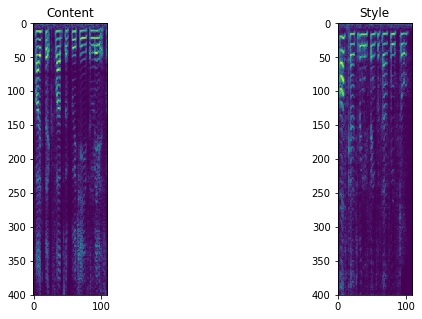

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

### Compute content and style feats

In [7]:
print(a_style.T.shape)
print(a_content.T.shape)
input_batch = np.asarray([a_style.T.tolist(), a_content.T.tolist()])
print(input_batch.shape)

(109, 1025)
(109, 1025)
(2, 109, 1025)


In [8]:
input_batch_placeholder = tf.placeholder(tf.float32, shape=(2, N_SAMPLES, N_CHANNELS), name="input_batch")
ae_outputs, layer_features, loss = conv_ae_with_loss(input_batch_placeholder, training=False)

print("Model created")
    
sess = tf.Session()
print("Initializaing vars")
sess.run(tf.global_variables_initializer())
print("Starting loading")

saver = tf.train.Saver()
saver.restore(sess, "last_checkpoint/hyperspectral_resnet.model-519")



Model created
Initializaing vars
Starting loading
INFO:tensorflow:Restoring parameters from last_checkpoint/hyperspectral_resnet.model-519


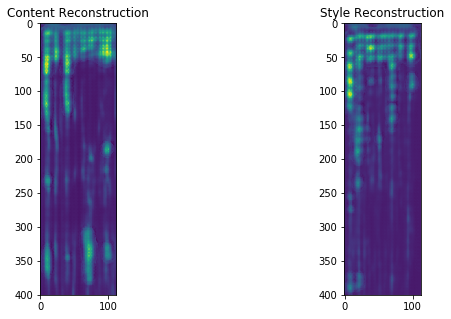

In [9]:
reconstruction = sess.run(ae_outputs, feed_dict={input_batch_placeholder:input_batch})
reconstruction = np.transpose(reconstruction, (0, 2, 1))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content Reconstruction')
plt.imshow(reconstruction[1, :400,:])
plt.subplot(1, 2, 2)
plt.title('Style Reconstruction')
plt.imshow(reconstruction[0, :400,:])
plt.show()

In [15]:
recon = np.zeros((1025, 109))
recon[:N_CHANNELS,:] = np.exp(reconstruction[1, :N_CHANNELS, :109]) - 1 # np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(recon.shape) - np.pi
for i in range(500):
    S = recon * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'content_reconstruction.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

content_reconstruction.wav


In [16]:
recon = np.zeros((1025, 109))
recon[:N_CHANNELS,:] = np.exp(reconstruction[0, :N_CHANNELS, :109]) - 1 # np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(recon.shape) - np.pi
for i in range(500):
    S = recon * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'style_reconstruction.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)
print(OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

style_reconstruction.wav


In [ ]:
def count_number_trainable_params():
    '''
    Counts the number of trainable variables.
    '''
    tot_nb_params = 0
    for trainable_variable in tf.trainable_variables():
        shape = trainable_variable.get_shape() # e.g [D,F] or [W,H,C]
        current_nb_params = get_nb_params_shape(shape)
        tot_nb_params = tot_nb_params + current_nb_params
    return tot_nb_params

def get_nb_params_shape(shape):
    '''
    Computes the total number of params for a given shap.
    Works for any number of shapes etc [D,F] or [W,H,C] computes D*F and W*H*C.
    '''
    nb_params = 1
    for dim in shape:
        nb_params = nb_params*int(dim)
    return nb_params 


In [13]:
N_SAMPLES*N_CHANNELS

440750